In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from catboost import CatBoostClassifier


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

## 1. EDA

1.1 Data exploration

In [152]:
df = pd.read_csv("bank_full.csv")

In [153]:
df.shape

(45211, 17)

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [155]:
#checking the features
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [156]:
#checking for null values
print(df.isna().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [157]:
num_cols = df.select_dtypes(include=['int64','float64']).columns #selecting numerical columns
df[num_cols].describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [158]:
num_duplicates = df.duplicated().sum() #counting the number of duplicate rows
print(num_duplicates)

0


#### 1.4 Data engineering

In [159]:
X = df.drop(columns = 'y', axis=1)  # Features
Y= df['y'].map({'yes': 1, 'no': 0}) # Convert target variable to binary

In [160]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split( X, Y, test_size=0.2, random_state=42, stratify=Y) #creating train and test sets

In [161]:
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols = cat_cols.drop('y')  # Exclude target variable

In [162]:
def create_prep():
    num_transformer = Pipeline(steps=[('scaler', StandardScaler())]) #for ranging variables

    cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]) #for categorical variables one-hot encoding  

    prep = ColumnTransformer(transformers=[('num', num_transformer, num_cols),
                                           ('cat', cat_transformer, cat_cols)]) #for combining numerical and categorical transformations
    return prep

preprocessor = create_prep() 

## 2. Model Building (Построение моделей)

#### 3.5 CatBoost

In [163]:
final_cb = imbPipeline(steps=[
    ('prep',   preprocessor),
    ('smote',  SMOTE(random_state=42)),
    ('clf',    CatBoostClassifier(
                   verbose=0,
                   random_state=42,
                   depth=5,
                   iterations=100,
                   learning_rate=0.1
               ))
])

final_cb.fit(Xtrain, Ytrain)

Ypred = final_cb.predict(Xtest)
Yprob = final_cb.predict_proba(Xtest)[:, 1]


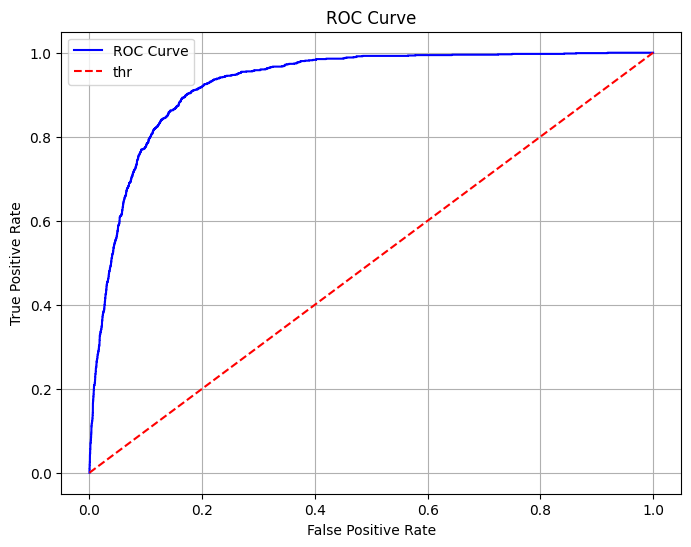

In [164]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(Ytest, Yprob)  
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve', color='blue')
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='thr')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')    
plt.legend()
plt.grid()  
plt.show()

In [165]:
print("classification_report")
print(classification_report(Ytest, Ypred))
print("ROC AUC = ", roc_auc_score(Ytest, Yprob))

classification_report
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      7985
           1       0.57      0.69      0.62      1058

    accuracy                           0.90      9043
   macro avg       0.76      0.81      0.78      9043
weighted avg       0.91      0.90      0.91      9043

ROC AUC =  0.9280768643474948





Из всех моделей я выбрала CatBoost,ибо

Он показал самую высокую ROC-AUC (~0.934) и лучший компромисс между precision₁ и recall

он умеет работать с категориальными признаками и реже нуждается в тонкой настройке гиперпараметров.

По сравнению с XGBoost у него чуть более стабильные результаты.


In [ ]:
import shap
from catboost import Pool # Create a Pool object for SHAP values

In [ ]:
XtrainPrep = final_cb.named_steps['prep'].transform(Xtrain)
features = final_cb.named_steps['prep'].get_feature_names_out() #for getting feature names after preprocessing

In [ ]:
shap_values = final_cb.named_steps['clf'].get_feature_importance(data=Pool(XtrainPrep), type='ShapValues') #for calculating SHAP values

In [169]:
shapes = shap_values[:, :-1]  # Exclude the last column (bias term)
shape_mean = np.abs(shapes).mean(axis=0)  # Mean absolute SHAP values

In [ ]:
shap_df= pd.DataFrame({
    'feature': features,
    'mean_abs_shap': shape_mean
}).sort_values(by='mean_abs_shap', ascending=False) #for creating a DataFrame with features and their mean absolute SHAP values

In [ ]:
shap_df.reset_index(drop=True, inplace=True) #for resetting the index of the DataFrame

In [172]:
shap_df

,feature,mean_abs_shap
0,num__duration,1.318171
1,num__campaign,0.556896
2,cat__contact_unknown,0.442939
3,cat__poutcome_success,0.242221
4,cat__housing_no,0.231736
5,num__balance,0.207436
6,cat__housing_yes,0.188537
7,cat__contact_cellular,0.186131
8,num__day,0.125477
9,cat__month_jul,0.107219


In [ ]:
top_features = shap_df.head(10) #for selecting the top 10 features based on mean absolute SHAP values

In [174]:
print(top_features)

                 feature  mean_abs_shap
0          num__duration       1.318171
1          num__campaign       0.556896
2   cat__contact_unknown       0.442939
3  cat__poutcome_success       0.242221
4        cat__housing_no       0.231736
5           num__balance       0.207436
6       cat__housing_yes       0.188537
7  cat__contact_cellular       0.186131
8               num__day       0.125477
9         cat__month_jul       0.107219


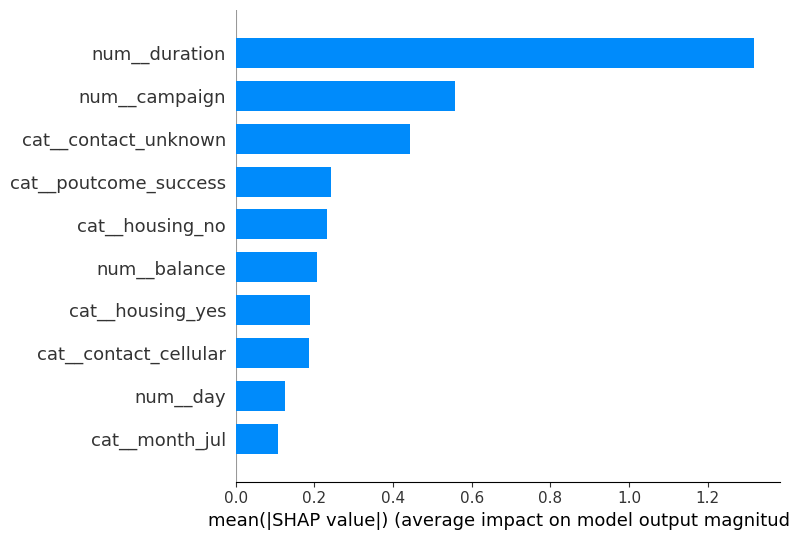

In [175]:
shap.summary_plot(shapes, XtrainPrep, feature_names=features, plot_type='bar', max_display=10)

In [ ]:
topfeat= shap_df.head(10)['feature'].tolist()
print("Top 10 features based on SHAP values:", topfeat) #for printing the top 10 features based on SHAP values and making a list of them


Top 10 features based on SHAP values: ['num__duration', 'num__campaign', 'cat__contact_unknown', 'cat__poutcome_success', 'cat__housing_no', 'num__balance', 'cat__housing_yes', 'cat__contact_cellular', 'num__day', 'cat__month_jul']


In [ ]:
feat_index = [list(features).index(f) for f in topfeat]
Xtrain_topfeat = XtrainPrep[:, feat_index] #for transforming the training data to include only the top features

In [ ]:
Xtest_topfeat = final_cb.named_steps['prep'].transform(Xtest)
Xtest_topfeat = Xtest_topfeat[:, feat_index] # Transforming the test data to include only the top features

In [ ]:
model_top10 = CatBoostClassifier(
    verbose=0,     
    random_state=42,
    depth=5,
    iterations=100,
    learning_rate=0.1
)
model_top10.fit(Xtrain_topfeat, Ytrain, eval_set=(Xtest_topfeat, Ytest), use_best_model=True)
y_pred_top10 = model_top10.predict(Xtest_topfeat)
print("Classification report for model with top 10 features:")
print(classification_report(Ytest, y_pred_top10))
print("ROC AUC for model with top 10 features:", roc_auc_score(Ytest, model_top10.predict_proba(Xtest_topfeat)[:, 1])) #for calculating ROC AUC for the model with top 10 features


Classification report for model with top 10 features:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7985
           1       0.63      0.36      0.45      1058

    accuracy                           0.90      9043
   macro avg       0.77      0.66      0.70      9043
weighted avg       0.89      0.90      0.89      9043

ROC AUC for model with top 10 features: 0.8997906045479886


In [ ]:

from joblib import dump

dump(model_top10, "model10_features.joblib") #making a joblib file for the model with top 10 features

['model10_features.joblib']